In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from src.domain import Domain
from src.interpolation import SplineInter
from src.transformations import Affine2d
from src.plotting import view_image_2d, plot_grid_2d
from src.super_resolution_tools import *
from src.transformations import Affine2d
from src.LinearOperator import LinearOperator
from src.lanczos import lanczos_tridiag
from src.conjugate_gradient import conjugate_gradient
from src.utils import * 
from src.optimization import *
import torch.func as func
from src.distance import SSDDistance
import time

torch.set_default_dtype(torch.float64)

In [2]:
def show_reference_and_templates(R, T):

    # Determine the layout for the subplots
    num_images = 1 + T.shape[0]  # Total number of images (reference + targets)
    cols = int(torch.ceil(torch.sqrt(torch.tensor(num_images).float())))  # Number of columns (and rows in a square layout)
    rows = int(torch.ceil(torch.tensor(num_images).float() / cols))  # Number of rows needed to accommodate all images

    # Create the figure with subplots
    _, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

    # Flatten the ax array for easier indexing
    ax = ax.flatten()

    # Display the reference image
    ax[0].imshow(R.detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
    ax[0].set_title('Reference')
    ax[0].axis('off')  # Optional: hide axes for cleaner visualization

    # Display the target images
    for k in range(T.shape[0]):
        ax[k + 1].imshow(T[k].detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
        ax[k + 1].set_title(f'T_{k}')
        ax[k + 1].axis('off')  # Optional: hide axes for cleaner visualization

    # Turn off any unused subplots
    for i in range(1 + T.shape[0], len(ax)):
        ax[i].axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
    plt.show()

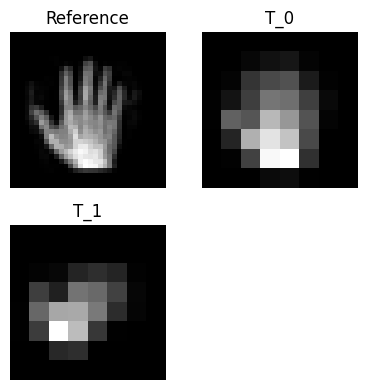

In [3]:
m = 32
factor = 4
theta = 0
n_images = 2

domain_R = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m, m)))
domain_R.m.detach()
domain_T = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m//factor, m//factor)))
xc = domain_R.getCellCenteredGrid().view(-1, 2).to(torch.float64)
times = torch.linspace(0, 15, n_images)

R = Image.open('../data/hands-R.jpg')
R = R.resize((m, m))
R = torch.fliplr(torch.tensor(R.getdata(), dtype=torch.float64).view(m,m).transpose(0,1))
Rimg = SplineInter(R, domain_R ,regularizer='moments',theta=theta).to(torch.float64)

def randomAffines(reference, n):
    affines = [getRandomAffine() for _ in range(n-1)]
    templates = [down_sample(reference(xc).reshape(m, m), factor)]
    for aff in affines:
        affine = Affine2d()
        affine.A = torch.nn.Parameter(aff[0].to(torch.float64))
        affine.b = torch.nn.Parameter(aff[1].to(torch.float64))
        templates.append(down_sample(reference(affine(xc)).reshape(m, m), factor))
    return torch.stack(templates)

T = randomAffines(Rimg, len(times))

show_reference_and_templates(R, T)

In [4]:
def L_forward(f):
    reference = f.reshape(*domain_R.m)
    diff_0 = torch.diff(reference, dim = 0) / domain_R.h[0]
    diff_1 = torch.diff(reference, dim = 1) / domain_R.h[1]
    return torch.hstack([diff_0.flatten(), diff_1.flatten()])

L = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=L_forward, dtype = torch.float64)

def K_forward(f):
    reference = f.reshape(*domain_R.m)
    downsampled = down_sample(reference, factor).flatten()
    return downsampled.flatten() 

K = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=K_forward, dtype = torch.float64)
f0_hat = K.T @ T[0].flatten().detach()


d = T.flatten()
b = torch.hstack([d * torch.sqrt(torch.prod(domain_T.h)), torch.zeros_like(L @ f0_hat)])

In [5]:
xc_2d = domain_R.getCellCenteredGrid()
xc = xc_2d.reshape(torch.prod(domain_R.m).item(),2).detach()

ys = [Affine2d() for _ in range(n_images)]
for y in ys:
    for param in y.parameters():
        param.to(torch.float64)
        param.requires_grad_(False)

lambdas = [1e-3]

wps = [{k: v.detach() for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec = torch.stack(flat_params_list).flatten().unsqueeze(1)


----------------------------------------------------------------------------------------------------
Registering Multiple Images :
----------------------------------------------------------------------------------------------------
Registering at Scale 0.001 with Gauss Newton
Checking Derivatives:
tensor(9147.9848)


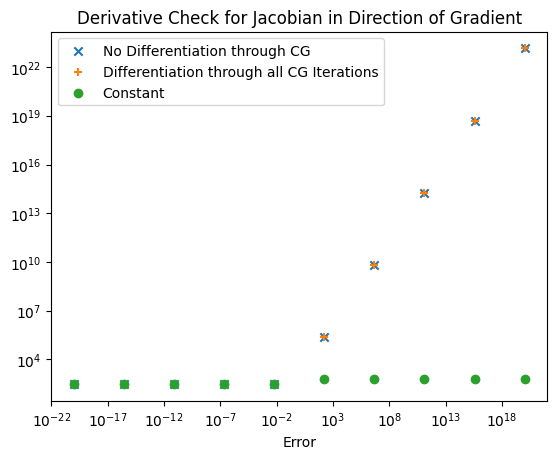

In [6]:
# Start Registration
print(100*'-')
print("Registering Multiple Images :")
print(100*'-')

for lam in lambdas:
    print("Registering at Scale {} with Gauss Newton".format(lam))

    def Forward_single(wp, y, f_inter):
        w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
        yc = func.functional_call(y, w_dict, xc)
        d_pred = K(f_inter(yc))
        return d_pred

    def res_fn(wp_vec):
        global f0_hat
        def A_forward(f):
            reference = f.reshape(*domain_R.m)        
            reference_img = SplineInter(reference, domain_R).to(torch.float64)
            template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

            regularizer = lam * L(f)
            
            return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                 regularizer * torch.sqrt(torch.prod(domain_R.h))])
        
        A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

        f0 = conjugate_gradient(A.T ^ A, A.T @ b, f0_hat, tol=0, max_iters=30,grad_iters=0)
        f0_hat = f0.detach()

        reference = f0.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R).to(torch.float64)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        return template_predictions - d

    def res_fn_nodiff(wp_vec):
        global f0_hat
        def A_forward(f):
            reference = f.reshape(*domain_R.m)        
            reference_img = SplineInter(reference, domain_R)
            template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

            regularizer = lam * L(f)
            
            return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                 regularizer * torch.sqrt(torch.prod(domain_R.h))])
        
        A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

        f0 = conjugate_gradient(A.T ^ A, A.T @ b, f0_hat, tol=0, max_iters=30)
        f0_hat = f0.detach()

        reference = f0.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        return template_predictions - d
    
    def Jac_fn(wp_vec):
        return func.jacfwd(res_fn)(wp_vec).detach().squeeze()
    
    def Jac_fn_nodiff(wp_vec):
        return func.jacfwd(res_fn_nodiff)(wp_vec).detach().squeeze()
    
    print("Checking Derivatives:")

    #print(Jac_fn_nodiff(wp_vec).shape)

    H = torch.logspace(20,-20,10)

    no_diffs = []
    diffs = []
    const = []

    v = Jac_fn(wp_vec).T @ res_fn(wp_vec)
    v /= torch.norm(v)

    res = res_fn(wp_vec)
    res_nodiff = res_fn_nodiff(wp_vec)
    Jacv_nodiff = Jac_fn_nodiff(wp_vec) @ v
    Jacv = Jac_fn(wp_vec) @ v

    for h in H:
        no_diffs.append(torch.norm(res_fn_nodiff(wp_vec + h * v) - res_nodiff - h * Jacv_nodiff).detach())
        diffs.append(torch.norm(res_fn(wp_vec + h * v) - res - h * Jacv).detach())
        const.append(torch.norm(res_fn(wp_vec + h * v) - res).detach())

    plt.scatter(H, no_diffs, marker='x', label = 'No Differentiation through CG')
    plt.scatter(H, diffs, marker='+', label = 'Differentiation through all CG Iterations')
    plt.scatter(H, const, marker='o', label = 'Constant')

    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    plt.legend()

    plt.xlabel("Perturbation Multiplier")
    plt.xlabel("Error")

    plt.title("Derivative Check for Jacobian in Direction of Gradient")

    print(torch.norm(Jac_fn(wp_vec) - Jac_fn_nodiff(wp_vec)))

    

    #wp_list, _  = lsq_lma(wp_vec.squeeze(), res_fn, Jac_fn, gtol=1e0, max_iter=10, verbose=True)
    #wp_vec = wp_list[-1]